In [1]:
# Imports
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
import json
import shutil
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from digit_train_dataset import digit_train_dataset
from digit_test_dataset import digit_test_dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 20

train_transforms = transforms.Compose([transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.ToTensor()])


# Load Data
train_dataset = ImageFolder(root = './dataset_images_keras/train/',
                             transform = train_transforms)
test_dataset = ImageFolder(root = './dataset_images_keras/test/',
                             transform = test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [4]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

Label: 0


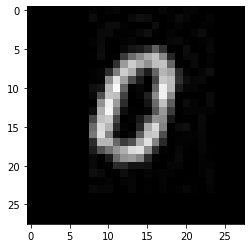

In [5]:
def show_image(image, label, dataset):
    print(f"Label: {label}") 
    plt.imshow(image.permute(1,2,0))
    plt.show()

show_image(*train_dataset[10], train_dataset)

In [21]:
# Model
model = torchvision.models.googlenet(pretrained=True)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [23]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier

In [24]:
model.to(device)

# Loss and optimizer
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    model.train()
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        optimizer.zero_grad()
        
        # forward
        scores = model.forward(data)

        loss = criterion(scores, targets)
        
        losses.append(loss.item())
        
        # backward
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()

    print(f'Cost at epoch {epoch} is {sum(losses)/len(losses)}')

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model.forward(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)


Cost at epoch 0 is 1.6454323786034433
Cost at epoch 1 is 1.38206800695968
Cost at epoch 2 is 1.3076217294283654
Cost at epoch 3 is 1.252568888609812
Cost at epoch 4 is 1.2014487021045597
Cost at epoch 5 is 1.1876714030901592
Cost at epoch 6 is 1.1860532466679403
Cost at epoch 7 is 1.1521303250909396
Cost at epoch 8 is 1.1313534768204712
Cost at epoch 9 is 1.1213193500422995
Cost at epoch 10 is 1.1187111386969752
Cost at epoch 11 is 1.109891947001627
Cost at epoch 12 is 1.0793025714077362
Cost at epoch 13 is 1.0812305171195775
Cost at epoch 14 is 1.079607795906938
Cost at epoch 15 is 1.0471017994837128
Cost at epoch 16 is 1.048043483740663
Cost at epoch 17 is 1.0458481134889333
Cost at epoch 18 is 1.0312264093525334
Cost at epoch 19 is 1.0160739234049025
Checking accuracy on Training Set
Got 5438 / 7000 with accuracy 77.69
Checking accuracy on Test Set
Got 1057 / 1500 with accuracy 70.47


In [5]:
# Model
model = torchvision.models.resnet18(pretrained=True)
documentation = {model: 0}
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 10)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier

In [10]:
model.to(device)

# Loss and optimizer
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    model.train()
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        optimizer.zero_grad()
        
        # forward
        scores = model.forward(data)

        loss = criterion(scores, targets)
        
        losses.append(loss.item())
        
        # backward
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()

    print(f'Cost at epoch {epoch} is {sum(losses)/len(losses)}')

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model.forward(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)


Cost at epoch 0 is 1.2066661163007832
Cost at epoch 1 is 0.8969151155861546
Cost at epoch 2 is 0.8173648373449229
Cost at epoch 3 is 0.7833944250187374
Cost at epoch 4 is 0.7567558317151788
Cost at epoch 5 is 0.7026795321675741
Cost at epoch 6 is 0.6614474617455104
Cost at epoch 7 is 0.6352756496978132
Cost at epoch 8 is 0.64341360677595
Cost at epoch 9 is 0.6243017825497884
Cost at epoch 10 is 0.5890419100789719
Cost at epoch 11 is 0.5523319651955338
Cost at epoch 12 is 0.5459088352445054
Cost at epoch 13 is 0.5359775814563716
Cost at epoch 14 is 0.5076438250470924
Cost at epoch 15 is 0.4975892592510676
Cost at epoch 16 is 0.4783170244329052
Cost at epoch 17 is 0.47889839286265307
Cost at epoch 18 is 0.4736648327819833
Cost at epoch 19 is 0.48888726457613246
Checking accuracy on Training Set
Got 6487 / 7000 with accuracy 92.67
Checking accuracy on Test Set
Got 1228 / 1500 with accuracy 81.87


In [7]:
checkpoint_path = "./Users/tobiasschulz/Documents/GitHub/digit_dataset/Classifier/saved_checkpoints/resnet/checkpoint.pth"
best_model_path = "./Users/tobiasschulz/Documents/GitHub/digit_dataset/Classifier/saved_pytorch_models/resnet/checkpoint.pth"

In [8]:
def train(start_epochs, n_epochs, valid_loss_min_input, checkpoint_path, best_model_path):
    """
    Keyword arguments:
    start_epochs -- the real part (default 0.0)
    n_epochs -- the imaginary part (default 0.0)
    valid_loss_min_input
    loaders
    model
    optimizer
    criterion
    use_cuda
    checkpoint_path
    best_model_path
    
    returns trained model
    """
    model.to(device)

    # Loss and optimizer
    criterion = nn.NLLLoss() 
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
    
    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 
    
    num_correct = 0
    num_samples = 0
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            # move to GPU
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(data)
            # calculate the batch loss
            loss = criterion(output, targets)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(test_loader):
            # move to GPU
            x = x.to(device=device)
            y = y.to(device=device)
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.forward(x)
            # calculate the batch loss
            loss = criterion(output, y)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            _, predictions = output.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
              
        
        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        # save checkpoint
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = valid_loss
    
    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    
    documentation = {model: float(num_correct)/float(num_samples)*100}
    
    # return trained model
    return model

In [9]:
trained_model = train(0, 20, 0.005, checkpoint_path, best_model_path)

Epoch: 0 	Training Loss: 0.000171 	Validation Loss: 0.000644


FileNotFoundError: [Errno 2] No such file or directory: './Users/tobiasschulz/Documents/GitHub/digit_dataset/Classifier/saved_checkpoints/resnet/checkpoint.pth'

In [ ]:
with open("documentation.json", "w") as outfile: 
    json.dump(documentaion, outfile) 

In [12]:
with open("sample_file.json", "r+") as file:
    data = json.load(file)
    data.update(documentation)
    file.seek(0)
    json.dump(data, file)